In [1]:
# script to run simulations of stream peppering
import os, os.path
import csv
import time
import pickle
import matplotlib
#matplotlib.use('agg')
import numpy
from scipy import integrate, interpolate
from optparse import OptionParser
from galpy.util import bovy_conversion
import gd1_util
import pal5_util
from gd1_util import R0,V0
from scipy.integrate import quad
from scipy.optimize import brentq
import GMC_GC_util
import glob
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
%pylab inline
from galpy.orbit import Orbit
from scipy import ndimage, signal, interpolate
from numpy.polynomial import Polynomial
from gd1_util_MWhaloshape import lb_to_phi12

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Do a Epanechnikov KDE estimate of the PDF in the transformed y=(1+x)/(1-x) space

def kde_epanechnikov_slope(x,h,ydata):
    
    h= numpy.ones_like(x)*h
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((2.6+x)/(-1.4-x))
    #print (y)
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*np.abs(1./(2.6+x) - 1./(1.4+x))

def kde_epanechnikov_amp(x,h,ydata):
    
    h= numpy.ones_like(x)*h
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((1.1+x)/(1.1-x))
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*(1./(1.1+x)+1./(1.1-x))

def kde_epanechnikov_1_over_mwdm(x,h,ydata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    h= numpy.ones_like(x)*h
    #h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((x-(0.01-0.005))/(1.1-x))
    #print (y)
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*np.abs(1./(x-(0.01-0.005)) + 1./(1.1-x))

def kde_epanechnikov_mwdm_uniform(x,h,xdata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    h= numpy.ones_like(x)*h
    ydata=numpy.log((xdata-(1. - 0.1))/(30.1-xdata))
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((x-(1.-0.1))/(30.1-x))
    #print (y)
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.),axis=1)/h*np.abs(1./(x-(1.-0.1)) + 1./(30.1-x))


def kde_epanechnikov_weighted_mwdm_uniform(x,h,xdata):
    """ydata= ln[(1+xdata)/(1-xdata)]"""
    h= numpy.ones_like(x)*h
    ydata=numpy.log((xdata-(1. - 0.1))/(30.1-xdata))
    h[x < -0.5]= h[x < -0.5]*(-2.*(x[x < -0.5]+0.5)+1.) # use slightly wider kernel at small values
    y= numpy.log((x-(1.-0.1))/(30.1-x))
    #print (y)
    #r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/h
    r= numpy.fabs(numpy.tile(y,(len(ydata),1)).T-ydata)/numpy.tile(h,(len(ydata),1)).T
    r[r > 1.]= 1. # Gets around multi-D slicing
    return numpy.sum(0.75*(1.-r**2.)/xdata**2.,axis=1)/h*np.abs(1./(x-(1.-0.1)) + 1./(30.1-x))


import seaborn as sns
def plot_pdf(rate_array,dat_type='rate',color=sns.color_palette()[0],zorder=8,
                  kernel_width=0.8,
                  add_68peak_95up=False,add_95up=False,add_95low=False,
                  overplot=False,
                  scale=1.,label=''):
    
    rate_full= np.array(rate_array)#abc_full[sindx,0]
       
    if dat_type == 'slope':
        xxs= numpy.linspace(-2.5,-1.5,101)
        kdey_full= kde_epanechnikov_slope(xxs,kernel_width,numpy.log((2.6+rate_full)/(-1.4-rate_full)))\
            +numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  

        #print (kdey_full)
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$\alpha = %.1f^{+%.1f}_{-%.1f} \ (68\,\%%)$' \
                                % (bf,uplim68-bf,bf-lowlim68)+'\n'+r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$\alpha >%.1f \ (95\,\%%)$' % (lowlim_95),
                               size=16.,top_left=True)

        legend(loc='upper right')
        return None
    
    elif dat_type == 'amp' : 
        xxs= numpy.linspace(-1.,1.,101)
        kdey_full= kde_epanechnikov_amp(xxs,kernel_width,numpy.log((1.1+rate_full)/(1.1-rate_full)))\
            +numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            bovy_plot.bovy_text(r'$\mathrm{amp} = %.1f^{+%.1f}_{-%.1f} \times \mathrm{CDM}\ (68\,\%%)$' \
                                % (10.**bf,10.**uplim68-10.**bf,10.**bf-10.**lowlim68)
                                +'\n'+r'$\mathrm{amp} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**uplim_95),
                               size=16.,top_left=True)
            
        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$\mathrm{amp} < %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$\mathrm{amp} > %.1f \times \mathrm{CDM}\ (95\,\%%)$' % (10.**lowlim_95),
                               size=16.,top_left=True)

                   
        legend(loc='upper right')
        return None
    
    elif dat_type=='1_over_mwdm':
        xxs= numpy.linspace(0.01,1.,101)
        kdey_full= kde_epanechnikov_1_over_mwdm(xxs,kernel_width,numpy.log((rate_full-(0.01 - 0.005))/(1.1-rate_full)))\
            +numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  

        #print (kdey_full)
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} = %.1f^{+%.1f}_{-%.1f} \ (68\,\%%)$' \
                                % (bf,uplim68-bf,bf-lowlim68)+'\n'+r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$1/m_{\mathrm{WDM}} < %.3f \ \mathrm{keV}^{-1} \ (95\,\%%)$' % (uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$1/m_{\mathrm{WDM}} >%.3f \ \mathrm{keV}^{-1} \ (95\,\%%)$' % (lowlim_95),
                               size=16.,top_left=True)

        legend(loc='upper right')
        
    elif dat_type=='uniform_mwdm':
        xxs= numpy.linspace(1.,30.,101)
        _kdey_full= kde_epanechnikov_mwdm_uniform(xxs,kernel_width,rate_full) +numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full= kde_epanechnikov_mwdm_uniform(xxs,kernel_width,rate_full) +numpy.random.uniform(size=len(xxs))*0.000001
        
        kdey_full/=xxs**2.
        
        _kdey_full/= numpy.sum(_kdey_full)*(xxs[1]-xxs[0]) 
        kdey_full/=np.sum(kdey_full)*(xxs[1]-xxs[0]) 
        
        #print (kdey_full)
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color='r',zorder=zorder,overplot=overplot,label=r'$\frac{1}{mwdm^{2}} \times \rm{PDF}$')
        bovy_plot.bovy_plot(xxs,_kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} = %.1f^{+%.1f}_{-%.1f} \ (68\,\%%)$' \
                                % (bf,uplim68-bf,bf-lowlim68)+'\n'+r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} < %.3f \ \mathrm{keV} \ (95\,\%%)$' % (uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} >%.3f \ \mathrm{keV} \ (95\,\%%)$' % (lowlim_95),
                               size=16.,top_left=True)

        legend(loc='lower left')
        
    elif dat_type=='weighted_mwdm_uniform':
        xxs= numpy.linspace(1.,29.,201)
        kdey_full= kde_epanechnikov_weighted_mwdm_uniform(xxs,kernel_width,rate_full)+numpy.random.uniform(size=len(xxs))*0.000001
        kdey_full/= numpy.sum(kdey_full)*(xxs[1]-xxs[0])  

        #print (kdey_full)
        bovy_plot.bovy_plot(xxs,kdey_full*scale,'-',lw=3.,color=color,zorder=zorder,overplot=overplot,label=label)
        if add_68peak_95up:
            # Get peak and 68% around the peak
            bf= xxs[numpy.argmax(kdey_full)]
            sindx= numpy.argsort(-kdey_full) # minus reverses sort
            cp= numpy.cumsum((kdey_full/numpy.sum(kdey_full))[sindx])
            m68= xxs[sindx][cp > 0.68]
            uplim68= numpy.amin(m68[m68 > bf])
            lowlim68= numpy.amax(m68[m68 < bf])
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} = %.1f^{+%.1f}_{-%.1f} \ (68\,\%%)$' \
                                % (bf,uplim68-bf,bf-lowlim68)+'\n'+r'$\alpha < %.1f \ (95\,\%%)$' % (uplim_95),
                                size=16.,top_left=True)


        if add_95up:
            # Get 95% upper limit
            cp= numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            uplim_95= interpolate.InterpolatedUnivariateSpline(cp,xxs,k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} < %.3f \ \mathrm{keV} \ (95\,\%%)$' % (uplim_95),
                               size=16.,top_left=True)

        if add_95low:
            # Get 95% lower limit
            #compute complementary CDF = 1- CDF
            ccp= numpy.ones(len(kdey_full)) - numpy.cumsum(kdey_full)/numpy.sum(kdey_full)
            lowlim_95= interpolate.InterpolatedUnivariateSpline(ccp[::-1],xxs[::-1],k=1)(0.95)
            bovy_plot.bovy_text(r'$m_{\mathrm{WDM}} >%.3f \ \mathrm{keV} \ (95\,\%%)$' % (lowlim_95),
                               size=16.,top_left=True)

        legend(loc='upper right')
        
        
        return None
    
def set_ranges_and_labels_dens():
    #bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$')
    ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$')
    ylim(0.01,20.)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None  

def set_ranges_and_labels_dens_noY():
    #bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$')
    ylim(0.001,20.)
    xlim(1.,150.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None 


### uniform in 1/mwdm

100899 1806


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


(0.0, 10.9)

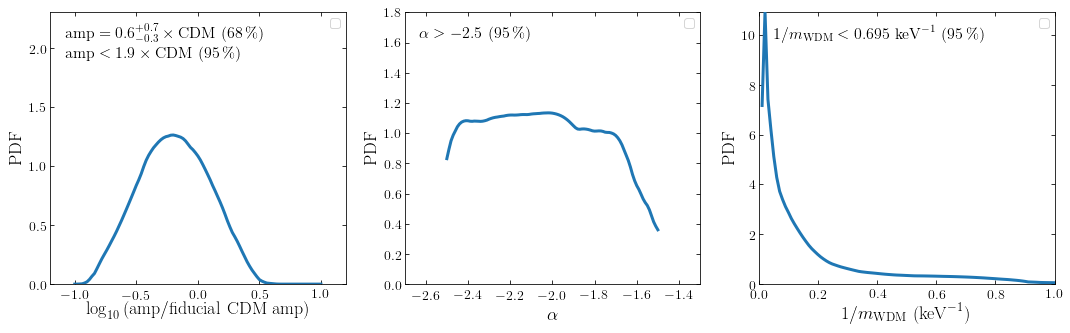

In [3]:
#read the diff file and construct the posterior after combining both the leading and trailing arm

dir2 = 'dens_Omega/sims_for_ABC_lognormalamp3.0sigma_slope_mwdm_margTage/'
gap_width=12.
c0kpc=2.02*10**(-13)

abc_diff_tr=np.loadtxt(dir2 + 'ABC_lognormalamp_slope_mwdm_power_diff_trailing_lenthreshold{}_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)
abc_diff_le=np.loadtxt(dir2 + 'ABC_lognormalamp_slope_mwdm_power_diff_leading_lenthreshold{}_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)

tol_tr_hi=0.5
tol_tr_med=0.4
tol_tr_lo=0.3
    

tol_le_hi=0.5
tol_le_med=0.4
tol_le_lo=0.3
   
accepted_slope=[]
accepted_amp=[]
accepted_1_over_mwdm=[]
accepted_Tage=[]
Tage_all=[]
amp_all=[]
slope_all=[]
inv_mwdm = []

NN=len(abc_diff_tr)


for ii in range(NN):
    #print (abc_diff[ii])
    amp=abc_diff_tr[ii][0]
    slope=abc_diff_tr[ii][1]
    mwdm=abc_diff_tr[ii][2]
    Tage=abc_diff_tr[ii][3]
    
    Tage_all.append(Tage)
    amp_all.append(amp)
    slope_all.append(slope)
    inv_mwdm.append(1./mwdm)
    
    
    #sl_all.append(slope)
    #amp_all.append(amp_all)
        
    #Trailing
    diff_tr_hi=abc_diff_tr[ii][4]
    diff_tr_med=abc_diff_tr[ii][5]
    diff_tr_lo=abc_diff_tr[ii][6]
    
    #Leading
    diff_le_hi=abc_diff_le[ii][4]
    diff_le_med=abc_diff_le[ii][5]
    diff_le_lo=abc_diff_le[ii][6]
    
    #print (diff_hi,diff_med,diff_lo)
    if (diff_tr_hi < tol_tr_hi) and (diff_tr_med < tol_tr_med) and (diff_tr_lo < tol_tr_lo) and (diff_le_hi < tol_le_hi) and (diff_le_med < tol_le_med) and (diff_le_lo < tol_le_lo):
    #if (diff_le_hi < tol_le_hi) and (diff_le_med < tol_le_med) and (diff_le_lo < tol_le_lo):    
        accepted_slope.append(slope)
        accepted_amp.append(amp)
        accepted_1_over_mwdm.append(1/mwdm)
        accepted_Tage.append(Tage)
                
print (len(abc_diff_tr), len(accepted_slope))

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(18.,5.)
cmap= cm.plasma
subplot(1,3,1)


plot_pdf(accepted_amp,dat_type='amp',kernel_width=0.7,add_68peak_95up=True,add_95low=False,scale=1.,label='',overplot=True)
xlabel(r'$\log_{10}\left(\mathrm{amp}/\mathrm{fiducial\ CDM\ amp}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-1.2,1.2)
ylim(0.,2.3)

subplot(1,3,2)
plot_pdf(accepted_slope,dat_type='slope',kernel_width=0.35,add_95low=True,scale=1.,label='',overplot=True)
xlabel(r'$\alpha$')
ylabel(r'$\mathrm{PDF}$')
xlim(-2.7,-1.3)
ylim(0.,1.8)

subplot(1,3,3)
plot_pdf(np.array(accepted_1_over_mwdm),dat_type='1_over_mwdm',add_95up=True,kernel_width=1.2,scale=1.,label=r'',overplot=True)
xlabel(r'$1/m_{\mathrm{WDM}} \ (\mathrm{keV}^{-1})$')
ylabel(r'$\mathrm{PDF}$')
xlim(0.,1.)
ylim(0.,10.9)
#savefig("posterior_lognormal3sigmaamp_slope_mwdm.pdf")

### uniform in mwdm 

100798 14131


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


(0.0, 0.14)

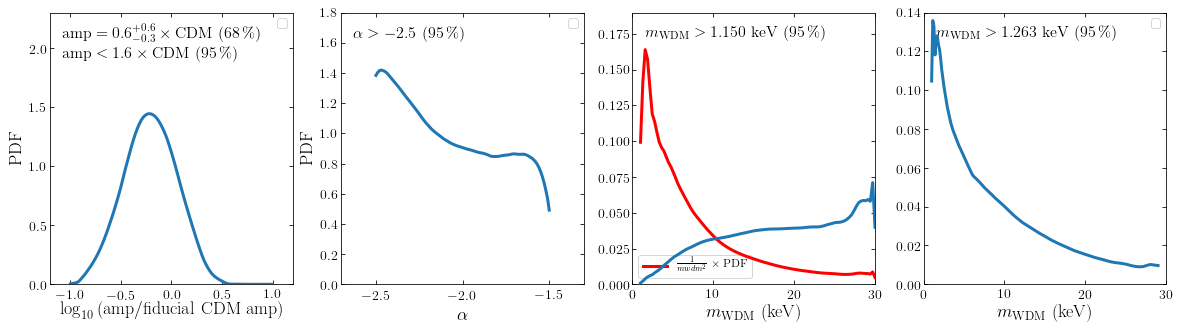

In [4]:
#read the diff file and construct the posterior after combining both the leading and trailing arm

dir2 = 'dens_Omega/sims_for_ABC_lognormalamp3.0sigma_slope_uniformmwdm_margTage/'
gap_width=12.
c0kpc=2.02*10**(-13)

abc_diff_tr=np.loadtxt(dir2 + 'ABC_lognormalamp_slope_mwdm_power_diff_trailing_lenthreshold{}_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)
abc_diff_le=np.loadtxt(dir2 + 'ABC_lognormalamp_slope_mwdm_power_diff_leading_lenthreshold{}_NRaoBlackwell{}.dat'.format(0.2,100),delimiter=',',skiprows=1)

tol_tr_hi=0.6
tol_tr_med=0.5
tol_tr_lo=0.4
    

tol_le_hi=0.6
tol_le_med=0.5
tol_le_lo=0.4
   
accepted_slope=[]
accepted_amp=[]
accepted_mwdm=[]
accepted_Tage=[]
Tage_all=[]
amp_all=[]
slope_all=[]
mwdm_all = []

NN=len(abc_diff_tr)


for ii in range(NN):
    #print (abc_diff[ii])
    amp=abc_diff_tr[ii][0]
    slope=abc_diff_tr[ii][1]
    mwdm=abc_diff_tr[ii][2]
    Tage=abc_diff_tr[ii][3]
    
    Tage_all.append(Tage)
    amp_all.append(amp)
    slope_all.append(slope)
    mwdm_all.append(mwdm)
    
    
    #sl_all.append(slope)
    #amp_all.append(amp_all)
        
    #Trailing
    diff_tr_hi=abc_diff_tr[ii][4]
    diff_tr_med=abc_diff_tr[ii][5]
    diff_tr_lo=abc_diff_tr[ii][6]
    
    #Leading
    diff_le_hi=abc_diff_le[ii][4]
    diff_le_med=abc_diff_le[ii][5]
    diff_le_lo=abc_diff_le[ii][6]
    
    #print (diff_hi,diff_med,diff_lo)
    if (diff_tr_hi < tol_tr_hi) and (diff_tr_med < tol_tr_med) and (diff_tr_lo < tol_tr_lo) and (diff_le_hi < tol_le_hi) and (diff_le_med < tol_le_med) and (diff_le_lo < tol_le_lo):
    #if (diff_le_hi < tol_le_hi) and (diff_le_med < tol_le_med) and (diff_le_lo < tol_le_lo):    
        accepted_slope.append(slope)
        accepted_amp.append(amp)
        accepted_mwdm.append(mwdm)
        accepted_Tage.append(Tage)
                
print (len(abc_diff_tr), len(accepted_slope))


bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(20.,5.)
cmap= cm.plasma
subplot(1,4,1)


plot_pdf(accepted_amp,dat_type='amp',kernel_width=0.7,add_68peak_95up=True,add_95low=False,scale=1.,label='',overplot=True)
xlabel(r'$\log_{10}\left(\mathrm{amp}/\mathrm{fiducial\ CDM\ amp}\right)$')
ylabel(r'$\mathrm{PDF}$')
xlim(-1.2,1.2)
ylim(0.,2.3)

subplot(1,4,2)
plot_pdf(accepted_slope,dat_type='slope',kernel_width=0.35,add_95low=True,scale=1.,label='',overplot=True)
xlabel(r'$\alpha$')
ylabel(r'$\mathrm{PDF}$')
xlim(-2.7,-1.3)
ylim(0.,1.8)

subplot(1,4,3)
plot_pdf(accepted_mwdm,dat_type='uniform_mwdm',add_68peak_95up=False,add_95low=True,kernel_width=1.2,scale=1.,overplot=True)
xlabel(r'$m_{\mathrm{WDM}} \ (\mathrm{keV})$')
#ylabel(r'$\mathrm{PDF}$')
xlim(0.,30.)
ylim(0.,0.19)

subplot(1,4,4)
plot_pdf(accepted_mwdm,dat_type='weighted_mwdm_uniform',add_68peak_95up=False,add_95low=True,kernel_width=1.2,scale=1.,overplot=True)
xlabel(r'$m_{\mathrm{WDM}} \ (\mathrm{keV})$')
#ylabel(r'$\mathrm{PDF}$')
xlim(0.,30.)
ylim(0.,0.14)
#savefig("posterior_lognormal3sigmaamp_slope_uniform_weighted_mwdm.pdf")